# Intro
### Motor-related signals in sensory areas
Movement-related activity has been shown to manifest in sensory areas of cortex. However, how motor plans affect sensory processing is not yet fully understood. For example, an animal must anticipate how perception of external stimuli will change when its sensory organs are moved and be able to compensate for this motion. In auditory cortex specifically, motor modulation of activity evoked by sounds associated with a particular movement has been well documented, even in head-fixed animals.

A limited range of motor actions are typically measured and analyzed during behavioral tasks, and only movements directly related to task performance, such as licking a spout or pulling a lever, are routinely analyzed with respect to neural activity. Recent work has demonstrated that this may limit the accuracy of interpretations of neural recordings. Task-performing animals display a rich repetoire of movements, including many movements which are unrelated to the task but can account for a substantial portion of cortical activity during task performance.
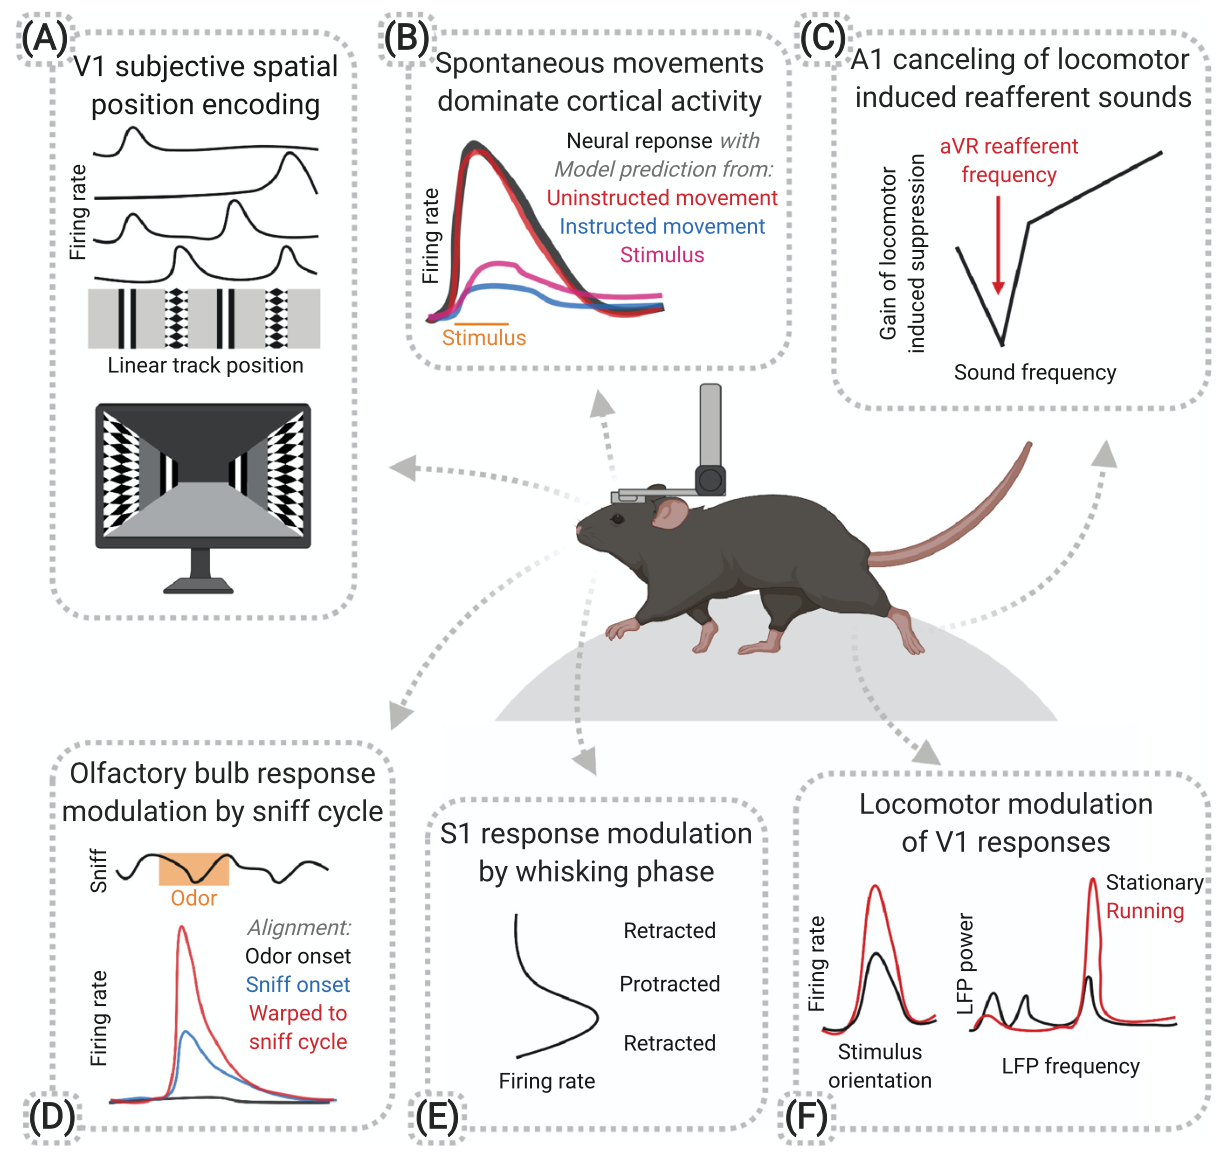

The implications of how uninstructed movements can factor into neural computations in sensory processing deserve to be explored in detail. Therefore, the goal of this notebook is to examine whether spontaneous facial movements during an auditory discrimination task can provide information about task performance.

Capturing a rich behavioral performance assay requires detection of a broader range of motor activity than can be obtained with simple motion sensors alone. For this reason, DeepLabCut (markerless pose estimation software) was used to track orofacial movements in videos recorded during lick-spout reinforcement training on an auditory discrimination task. On each trial, the head-fixed water-restricted animal is exposed to noise and a target tone and must lick to initiate liquid reward within 1.5s of hearing the target.

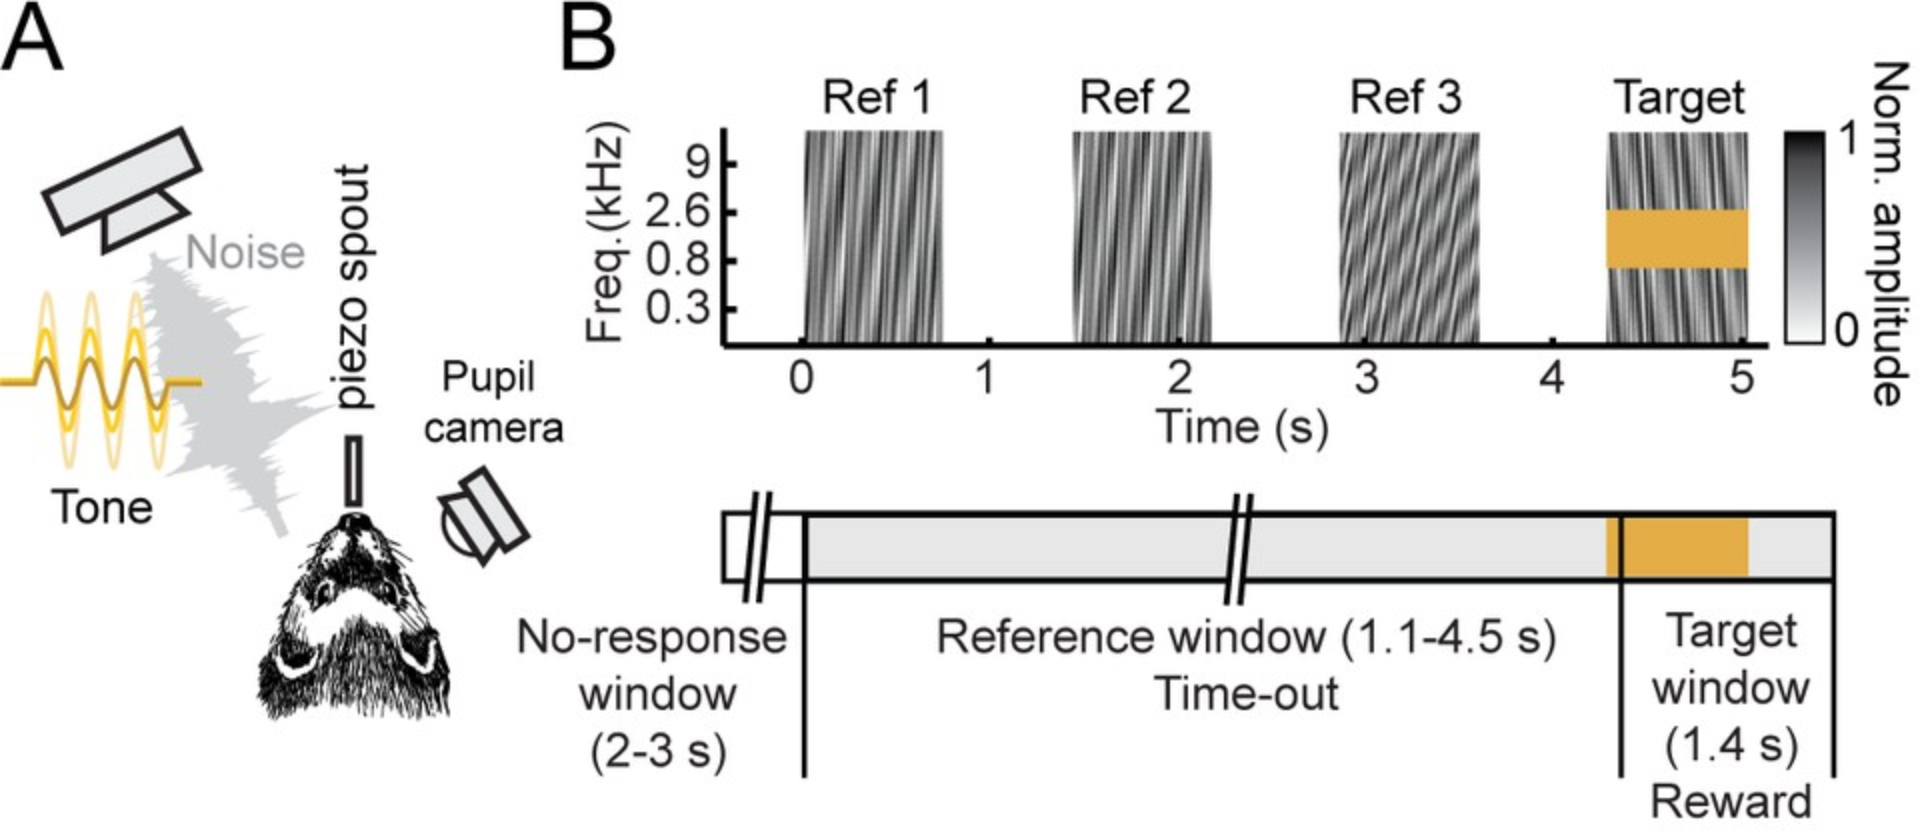




# Getting a sense of DeepLabCut (DLC) data

In [ ]:
#stardard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#for PCA
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

### Markers applied to a training video

Once a DLC model is trained on videos that you've provided, it is then used to estimate bodypart positions on new videos. The model that was used to applied these labels was trained on 150 manually-labeled frames across 3 videos, then re-trained with an additional 128 manually-corrected frames (which sounds like it would take a really long time, but it actually goes pretty quickly!)

(Play demo video here.)

### Results are provided in hierarchical data format

As we discussed in a previous class, this is a great way to store a lot of data. For example, the DLC output for this 40-min video has over 90,000 rows. As a csv, this would be ~30MB, but as an HDF5 it only takes up ~16MB. Another benefit is that HDF5 files are easy to work with using pandas.

In [ ]:
#load DLC marker data
df = pd.read_hdf('data/DLC_data.h5')
df

## Plotting DLC output

In [ ]:
#extracting marker info
scorer = df.columns[0][0]
dlc_data = df[scorer] #gets rid of scorer index
bp_index = dlc_data.columns.get_level_values(0)[::3]
bodyparts = bp_index.tolist()

print(bodyparts)
dlc_data.head(3)

## Exercise - use logical indexing to extract the data above a likelihood threshold

Because some body parts like the tongue and chin are not always in the frame, the DLC model can't predict their locations as accurately as other body parts. This is quantified in the `likelihood` values given for the coordinates at each frame. Using logical indexing, we can extract the coordinates that are above a certain threshold value.

In [ ]:
#to extract a subset of x coordinates for one bodypart:
tongue_x = dlc_data['tongue']['x'][:10]

#to filter coordinates using logical indexing:
threshold = 0.00005
threshold_check = dlc_data['tongue']['likelihood'][:10].values > threshold
tongue_above_threshold = dlc_data['tongue']['x'][:10][threshold_check]

print(threshold_check) #a boolean array indicating which indices have an x value above threshold
print(tongue_x) #the orignal subset of x coordinates
print(tongue_above_threshold) #the subset of coordinates that are above threshold

Basing your answer off the code provided above, determine how many of the x coordinates for the `chin` marker are above a likelihood threshold of `0.5`. Store the values in `chin_above_thresold`, then use `len()` to see how many frames remain, compared to the original number of frames in the data.

`Hint:` Remember to remove all instances of `[:10]` in the code, since we want to threshold all the data instead of just a short segment.

In [ ]:
#Answer
threshold = 0.5
threshold_check = dlc_data['chin']['likelihood'].values > threshold
chin_above_threshold = dlc_data['chin']['x'][threshold_check]

print('original number of frames:',len(dlc_data))
print('frames above threshold:',len(chin_above_threshold))

### Plotting marker trajectories

DLC has a built-in function to do something similar, but plotting it ourselves means we can customize it. Here, we have a screencap from the video underneath the marker positions, which are plotted semi-transparent so that the more markers there are in a particular spot, the more opaque they appear. And as you just practiced above, we use logical indexing to plot only the marker coordinates above a threshold of 0.5.

In [ ]:
img = plt.imread('data/baseline.png')
plt.figure(figsize=(12,6))
plt.imshow(img, alpha=0.5)

color=plt.cm.rainbow(np.linspace(0,1,len(bodyparts)))
for i,bp in enumerate(bodyparts):
    threshold_check = dlc_data[bp]['likelihood'].values > 0.5
    plt.plot(dlc_data[bp]['x'][threshold_check], dlc_data[bp]['y'][threshold_check], '.', color=color[i], alpha=0.1)
plt.legend(bodyparts, loc=(1,0.2));
plt.ylim([240,0]);
plt.xlabel('position (pixels)')
plt.ylabel('position (pixels)')
plt.title('DLC marker trajectories');

# Using PCA to reduce dimensionality

As could be seen in the dataframe, each bodypart that is labeled with DLC will be represented as 3 values per frame after DLC labels are applied: an x coordinate, a y coordinate, and a likelihood value. In this example data, there are 7 bodyparts i.e. there are 21 different traces for this single video. To make the data easier to analyze, we will reduce the dimensionality.

The new file we are importing (dlc_data.csv) is a copy of the same data we just looked at, but with a likelihood threshold of 0.25 has been applied along with some special calculations to align the marker data with some task data we will be looking at later. The way this threshold has been applied, any value below threshold is replaced by NaN, so to perform PCA, we will impute these values i.e. replace them with the mean for that bodypart.

### Preparing the data for PCA

Remember PCA from a few classes ago? We'll be using the implementation from sklearn here. This approach makes implementation easy, but also allows you to visualize the details of the PC space as needed.

In [ ]:
data_array = np.loadtxt('data/dlc_data.csv',delimiter=',')
num_frames = data_array.shape[1]
dlc_data.shape
imp = SimpleImputer(missing_values=np.nan, strategy='mean') #replace NaN values with mean
filled = imp.fit_transform(data_array.T)
scaler = StandardScaler() #normalize to mean
X = scaler.fit_transform(filled)

Standard procedure for sklearn models. Pre-process the data matrix to be sample (time) $\times$ channel (feature), then feed it to an instance of the `PCA` object.

In [ ]:
pca = PCA() #create PC object
Xpca = pca.fit_transform(X) #fit model + apply dimensionality reduction
cov = pca.get_covariance() #compute covariance matrix

### Covariance matrix

Previously we computed the covariance matrix with a sequence of numpy operations. Here, sklearn takes care of it for us.

In [ ]:
#graph covariance matrix
bp_coords = []
for bp in bodyparts:
    bp_coords.append(bp+"_x")
    bp_coords.append(bp+"_y")

plt.imshow(cov,extent=[0,14,0,14]);
plt.xticks(np.arange(14), bp_coords, rotation=70);
plt.yticks(np.arange(14), bp_coords);
plt.colorbar()
plt.show()

## Exercise - Visualize the relative weights for PCs 1 and 2

### Eigenvector plot
Plotting the eigenvectors lets us see the weights for each individual bodypart, i.e. how much its position contributes to that PC. There is some sign ambiguity in the sklearn PCA, so looking at the magnitude for each bodypart tells us its contribution (i.e. ignoring positive vs negative).

Using `bp_coords` as the x values and a column of `pca.components_` as the y values, we can plot the relative weight for all 14 features i.e. the x and y coordinates for all 7 bodyparts.

In [ ]:
plt.plot(bp_coords, pca.components_[:,0]); #plot of PC1 weights

Use the above code to plot the weights for PC1 and PC2 (`pca.components_[:,:2]`). Additionally, make the plot more readable by using the `rotation` parameter of `plt.xticks` to rotate the bodypart coordinate labels until they are readable.

Optional changes: add a legend, axis labels, a title, and a dotted horizontal line at y=0

In [ ]:
#Answer
plt.figure(figsize=(10,5))
plt.plot(bp_coords, pca.components_[:,:2])
plt.legend(['PC1', 'PC2'], loc=(1.04,0.5))
plt.axhline(y=0,color='k',linestyle='--')
plt.xticks(rotation=60);
plt.ylabel('score')
plt.title('facial marker eigenvectors');

Looking at the weights, we can see the the eyelids and whisker seem to dominate the first two PCs.

Plotting these 2 PCs over the first 900 frames of the video (the first 30 seconds) lets us see how they are changing over time, which will correspond to what type of facial movement they are tracking.

In [ ]:
#view PCs over time
plt.figure(figsize=(12,4))
plt.plot(Xpca[:900,0], label='PC1')
plt.plot(Xpca[:900,1], label='PC2')
plt.legend(loc=(1.04,0.5))
plt.xlabel('frames')
plt.ylabel('score')
plt.title('facial movements in PC space');
plt.show()

### Using PCs to categorize different movements

These PCs are great, but what do they *mean*?

Here we define a function to project back out of PC space, essentially recreating the original data using only one principal component i.e. one dimension. By doing this, we can see what type of movement each PC is representing when we look at the bodypart markers.

$\text{PCA reconstruction}=\text{PC scores}*\text{Eigenvectors}^⊤+\text{Mean}$




In [ ]:
def invert_PCA(X, Xpca, pc_index):
    '''
    X: imputed data
    Xpca: PCA data
    pc_index: which PC
    '''
    PC = Xpca[:,[pc_index]]
    evec = pca.components_[:,[pc_index]]
    movement = evec @ PC.T + np.nanmean(X.T, axis=1, keepdims=True)
    
    return movement

When we plot reconstructed data alongside the original data, we can appreciate how dimensionality reduction makes the data much simpler, and excludes some detail. We can also see how each PC is tracking a different motor pattern.

In [ ]:
mean_vals = np.nanmean(filled.T, axis=1, keepdims=True)

movement1 = invert_PCA(filled, Xpca, 0)
movement2 = invert_PCA(filled, Xpca, 1)

f,ax=plt.subplots(3,1,figsize=(12,6), sharex=True)

ax[0].imshow(filled.T[:,:900]-mean_vals, aspect='auto')
ax[0].set_yticks(np.arange(14))
ax[0].set_yticklabels(bp_coords, fontsize=8)
ax[0].title.set_text('original data')

ax[1].imshow(movement1[:,:900]-mean_vals, aspect='auto')
ax[1].set_yticks(np.arange(14))
ax[1].set_yticklabels(bp_coords, fontsize=8)
ax[1].title.set_text('reconstructed using PC1')

ax[2].imshow(movement2[:,:900]-mean_vals, aspect='auto')
ax[2].set_yticks(np.arange(14))
ax[2].set_yticklabels(bp_coords, fontsize=8)
ax[2].title.set_text('reconstructed using PC2')
ax[2].set_xlabel('frame');

## Exercise - Align the PCs to the reconstructed data

Using the code above for heatmaps, recreate the PC1 and PC2 reconstruction plots and add a plot of PC1 and PC2 over time (`Xpca[:900,:2]`) underneath the heatmap plots. All 3 subplots should be aligned on the same x axis.

In [ ]:
#Answer
f,ax=plt.subplots(3,1,figsize=(12,6), sharex=True)

ax[0].imshow(movement1[:,:900]-mean_vals, aspect='auto')
ax[0].set_yticks(np.arange(14))
ax[0].set_yticklabels(bp_coords, fontsize=8)
ax[0].title.set_text('reconstructed using PC1')

ax[1].imshow(movement2[:,:900]-mean_vals, aspect='auto')
ax[1].set_yticks(np.arange(14))
ax[1].set_yticklabels(bp_coords, fontsize=8)
ax[1].title.set_text('reconstructed using PC2')

ax[2].plot(Xpca[:900,:2]);
ax[2].title.set_text('first 2 PCs over time')
ax[2].set_xlabel('frame')
ax[2].set_ylabel('score')
ax[2].legend(['PC1','PC2']);

Now if we check the original video and look at which PC tracks which movement...

(Play video here)

... we can see that PC1 is tracking face licks while PC2 is tracking spout licks!

## Plotting modes of motion

When we plot the reconstructed data from each PC on top of a screencap from the video, we see the subspace of vectors for each bodypart.

In [ ]:
plt.figure(figsize=(12,6))
img = plt.imread('data/baseline.png')
plt.imshow(img, alpha=0.5)
for i in range(len(bodyparts)):
    plt.plot(movement1[2*i,::100],movement1[2*i+1,::100],linewidth=3,color='b', )
    plt.plot(movement2[2*i,::100],movement2[2*i+1,::100],linewidth=2,color='r')
plt.legend(['PC1','PC2']);

# Analyzing facial movement data with respect to task

Now that we have reduced the dimensionality of our DLC data, we can analyze whether this data can be used to predict whether the trial outcome will be a hit (reward delivered) or a miss (no response, no reward).

In [ ]:
#import the task data
task_data = pd.read_csv('data/task_data.csv')
task_data

Define a few high-level variables to specify the time window of analysis around important events.

In [ ]:
#set parameters
pre_sec = 2
post_sec = 2
fps = 30

Here we define a function to make slicing out pre-trial data easier and faster.

In [ ]:
def PC_trials(Xpca, pc_index, trialtype, task_data, pre_sec=2, post_sec=2, fps=30):
    '''
    Extract PC values from a window of time around trial start.
    inputs:
        Xpca: array of PCA data
        pc_index: index of PC to extract data from
        trialtype: trial outcome ID as str (e.g. 'HIT_TRIAL', 'MISS_TRIAL')
        pre_sec: number of seconds before trial start, when to begin extracting data
        post_sec: number of seconds after trial start, when to stop extracting data
        fps: frames per second
    outputs:
        pretrial_pc: array of PC values from pre_sec before trial onset to post_sec after trial onset
    '''
    
    PC = Xpca[:,[pc_index]].T
    
    trials = task_data.loc[(task_data.name==trialtype)].copy()
    if trials.iloc[0,1]<pre_sec:
        trials=trials.iloc[1:,:] #remove first trial if not enough pre-trial time
    num_trials = len(trials)
    
    num_pre_frames = pre_sec * fps
    num_post_frames = post_sec * fps
    trial_frames = (trials['start'].values*fps).astype(int)
    pre_frames = (trial_frames - num_pre_frames)
    post_frames = (trial_frames + num_post_frames)
    
    pretrial_pc = np.zeros((num_trials, num_pre_frames+num_post_frames)) 
    for n in range(num_trials):
        pretrial_pc[n] = PC[0,pre_frames[n]:post_frames[n]]
        
    return pretrial_pc

We can plot the data we just extracted to see how PC1 and PC2 behave around the start of trials.

In [ ]:
#plotting
PC1_hit = PC_trials(Xpca, 0, 'HIT_TRIAL', task_data)
PC2_hit = PC_trials(Xpca, 1, 'HIT_TRIAL', task_data)

t = np.arange(len(PC1_hit[1])) / fps - pre_sec #get pre trial time axis in seconds

for p in range(len(PC1_hit)):
    plt.plot(t, PC1_hit[p], color='b');
    plt.plot(t, PC2_hit[p], color='r');

plt.title('hit trials (n={})'.format(len(PC1_hit)))
plt.xlabel('time relative to trial onset (s)')
plt.ylabel('score')
plt.legend(['PC1','PC2']);

## Exercise - Plotting PC behavior
Use the above code to plot PC1 and PC2 for all the miss trials. Note that you will have to change the y axis limits to `[-5,15]` to compare it to the hit data.

In [ ]:
#Answer
PC1_miss = PC_trials(Xpca, 0, 'MISS_TRIAL', task_data)
PC2_miss = PC_trials(Xpca, 1, 'MISS_TRIAL', task_data)

for p in range(len(PC1_miss)):
    plt.plot(t, PC1_miss[p], color='b');
    plt.plot(t, PC2_miss[p], color='r');

plt.title('miss trials (n={})'.format(len(PC1_miss)))
plt.xlabel('time relative to trial onset (s)')
plt.ylabel('score')
plt.ylim([-5,15])
plt.legend(['PC1','PC2']);

We can see PC2 tracking licks soon after the onset of hit trials but not miss trials, so we can confirm that our PCs are representing our data.

### Permutation testing: can pre-trial facial movements predict hits vs misses?

Here we define the functions for permutation testing that we created in week 5.

In [ ]:
def my_absolute_mean_difference(a,b):
    """
    Helper function for flexible_permutation_test, compute the absolute mean difference between a and b
    """
    m = np.abs(a.mean()-b.mean())
    return m


def flexible_permutation_test(a, b, myfunc, N=100, verbose=False):
    """
    Permutation to test whether the the value of myfunc(a,b) is significantly greater 
    than expected by chance.
    inputs:
       a, b: 1-D distributions of data
       myfunc: user-defined function such that stat=myfunc(a,b) returns a scalar value
            stat, which can be evaluated over permutations of a and b
       N: number of permutations
       verbose: plot a histrogram of the shuffled data, helpful for debugging.
    outputs:
       p: p-value, how likely the actual value occurred by chance
    """
    # first, compute the shuffled mean differences
    shuffled_distribution = np.zeros(N)
    for i in range(N):
        all_data = np.append(a, b)
        s = np.random.permutation(all_data)
        a_shuffled = s[:len(a)]
        b_shuffled = s[len(a):]
        shuffled_distribution[i] = myfunc(a_shuffled,b_shuffled)
    
    # now compute p
    actual_value = myfunc(a,b)
    effective_distribution = np.append(shuffled_distribution, actual_value)

    total_N = len(effective_distribution)
    greater_equal_N = np.sum(np.abs(effective_distribution) >= actual_value)
    p = greater_equal_N / total_N
    
    if verbose:
        plt.figure()
        plt.hist(shuffled_distribution, label='shuffled')
        plt.axvline(actual_value, color='r', label='acutal')
        plt.xlabel('statistic')
        plt.ylabel('count')
        plt.legend()
        print('p = {}'.format(p))

In [ ]:
#get pre-trial PC data for all trials with each outcome
prehit_PC1 = PC_trials(Xpca, 0, 'HIT_TRIAL', task_data, post_sec=0)
premiss_PC1 = PC_trials(Xpca, 0, 'MISS_TRIAL', task_data, post_sec=0)

#get overall PC variance during the 2-sec window before each trial
prehit_PC1_var = np.std(prehit_PC1, axis=1)
premiss_PC1_var = np.std(premiss_PC1, axis=1)

In [ ]:
flexible_permutation_test(prehit_PC1, premiss_PC1, my_absolute_mean_difference, N=1000, verbose=True)
plt.title('PC1 score');

flexible_permutation_test(prehit_PC1_var, premiss_PC1_var, my_absolute_mean_difference, N=1000, verbose=True)
plt.title('PC1 variance');

## Exercise - Permutation test on PC2 for hits vs misses

Copy and modify the code above to perform a permuation test to see if PC2 differs before hit and miss trials

In [ ]:
#Answer
prehit_PC2 = PC_trials(Xpca, 1, 'HIT_TRIAL', task_data, post_sec=0)
prehit_PC2_var = np.std(prehit_PC2, axis=1)

premiss_PC2 = PC_trials(Xpca, 1, 'MISS_TRIAL', task_data, post_sec=0)
premiss_PC2_var = np.std(premiss_PC2, axis=1)

flexible_permutation_test(prehit_PC2, premiss_PC2, my_absolute_mean_difference, N=1000, verbose=True)
plt.title('PC2 score');

flexible_permutation_test(prehit_PC2_var, premiss_PC2_var, my_absolute_mean_difference, N=1000, verbose=True)
plt.title('PC2 variance');

# Bonus - slow changes in arousal

Your eyelids get droopy when tired. A quick way of assessing arousal, similar to pupil size, is to measure slow changes in the distance between upper and lower eyelids.

Eyelid separation can be measured as the Euclidean distance between eyelids. Remember which channels of the `filled` matrix correspond to eyelid.

In [ ]:
bodyparts

In [ ]:
eye_dist_x = filled[:,0]-filled[:,2]
eye_dist_y = filled[:,1]-filled[:,3]
eye_separation = np.sqrt(eye_dist_x**2 + eye_dist_y**2)

f,ax = plt.subplots(2,1,figsize=(10,4))
ax[0].plot(eye_dist_x[:10000])
ax[0].plot(eye_dist_y[:10000])
ax[0].legend(('eye x dist','eye y dist'))
ax[1].plot(eye_separation[:10000]);
ax[1].set_ylabel('eyelid separation')
ax[1].set_xlabel('video frame')

This is kind of messy, because rapid events (licks, blinks) also create eyelid movements.

## Exercise - remove noise from arousal metric

Remember our filter operations from week 6?  We can use `scipy.signal.butter` and `scipy.signal.sosfilt` to low-pass filter `eye_separation`. Use `order=5`, and `passband` should be 0.02 Hz (this is equivalent to 1 cycle every 50 seconds). Save the smoothed signal as `eye_sep_smooth` and plot it.

In [ ]:
import scipy.signal

In [ ]:
# Answer
order = 5
passband = 0.02
sos = scipy.signal.butter(order, passband, 'lowpass', fs=fps, output='sos')

eye_sep_smooth = scipy.signal.sosfilt(sos, eye_separation)
plt.figure(figsize=(10,2))
plt.plot(eye_sep_smooth)
plt.xlabel('video frame')
plt.ylabel('eyelid separation')

The first few frames look funny because the low-pass filter filled in zeros before the onset of the data, replotting without the first 50 seconds (1500 frames) removes this artifact

In [ ]:
plt.figure(figsize=(10,2))

plt.plot(eye_sep_smooth[1500:])
plt.xlabel('video frame')
plt.ylabel('eyelid separation')